# Init

## Computation

### GPU

In [1]:
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

# Create a Dask Cluster with one worker per GPU
cluster = LocalCUDACluster(memory_limit='2GB')
client_gpu = Client(cluster)
client_gpu

<Client: 'tcp://127.0.0.1:46449' processes=1 threads=1, memory=2.00 GB>

### CPU

In [1]:
from dask.distributed import Client, LocalCluster

# client_cpu = Client(processes=False, threads_per_worker=4,
#                 n_workers=1, memory_limit='4GB')

cluster = LocalCluster(processes=False, memory_limit='8GB')
client_cpu = Client(cluster)
client_cpu

<Client: 'inproc://192.168.0.103/18388/1' processes=1 threads=4, memory=8.00 GB>

## Import libs

### Plotly

In [2]:
import plotly.graph_objects as go
# import plotly.io as pio
# pio.templates.default = 'plotly_dark'

### Other

In [3]:
import dask.array as da
import cupy as cp

# Problem

$$x_0, \, x_1 \sim \mathcal {U}[0, 1]$$
$$a = \min \left\{x_0, \, x_1\right\}$$
$$b = \max \left\{x_0, \, x_1\right\} - \min \left\{x_0, \, x_1\right\}$$
$$c = 1 - \max \left\{x_0, \, x_1\right\}$$
$$P\left( a + b > c, \, c + a > b, \, b + c > a \right) \, ?$$

# Solve I

## CPU

dask.array<broadcast_to, shape=(10000, 10000), dtype=float64, chunksize=(2000, 2000), chunktype=numpy.ndarray>

dask.array<coarsen, shape=(200, 200), dtype=float64, chunksize=(40, 40), chunktype=numpy.ndarray>

CPU times: user 23.3 ms, sys: 0 ns, total: 23.3 ms
Wall time: 25.5 ms
CPU times: user 10.7 s, sys: 2.04 s, total: 12.7 s
Wall time: 5.1 s


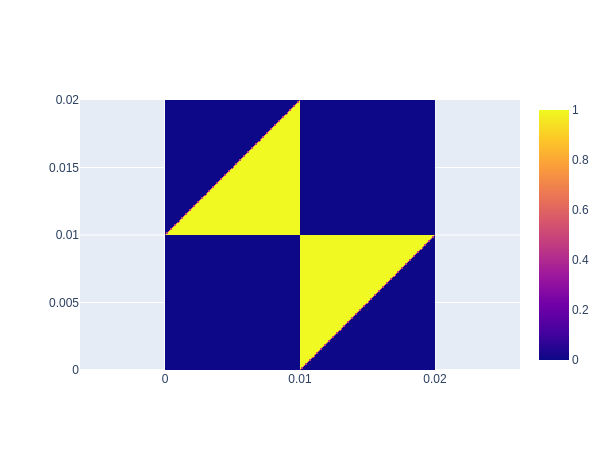

In [5]:
w, h = 2e2, 2e2
nx, ny = 1e4, 1e4
cx, cy = 2e3, 2e3

x = da.linspace(0, 1, nx, chunks=cx)
y = da.linspace(0, 1, ny, chunks=cy)
# y = da.linspace(0, 1, 10e3)[:, None].rechunk(chunks=1e3)

xx, yy = da.meshgrid(x, y)
# xx, yy = x, y
display(xx)

istriangle = lambda a, b, c: (a + b > c) & (c + a > b) & (b + c > a)

# x < y
a = xx; b = yy - xx; c = 1 - yy
cond0 = istriangle(a, b, c) & (xx < yy)

# x > y
a = yy; b = xx - yy; c = 1 - xx
cond1 = istriangle(a, b, c) & (xx > yy)

cond = cond0 | cond1

dx, dy = nx // w, ny // h
cond_resmpl = da.coarsen(da.mean, cond, {0: int(dx), 1: int(dy)})#, trim_excess=True)
display(cond_resmpl)
# cond0_resmpl, = dask.optimize(cond_resmpl)
# display(cond_resmpl)

x_r, y_r = x[::dx], y[::dy]
xx_r, yy_r = da.meshgrid(x_r, y_r)
xc, yc = %time da.compute(x, y)
cond_resmpl_c = %time cond_resmpl.compute()

data = go.Heatmap(x=x, y=y, z=cond_resmpl_c)

layout = go.Layout(yaxis=dict(scaleanchor="x", scaleratio=1))

fig = go.Figure(data, layout)

fig.show()

## GPU

dask.array<broadcast_to, shape=(10000, 10000), dtype=float64, chunksize=(2000, 2000), chunktype=numpy.ndarray>

dask.array<coarsen, shape=(200, 200), dtype=float64, chunksize=(40, 40), chunktype=numpy.ndarray>

CPU times: user 115 ms, sys: 6.67 ms, total: 121 ms
Wall time: 614 ms
CPU times: user 329 ms, sys: 26.3 ms, total: 356 ms
Wall time: 1.7 s


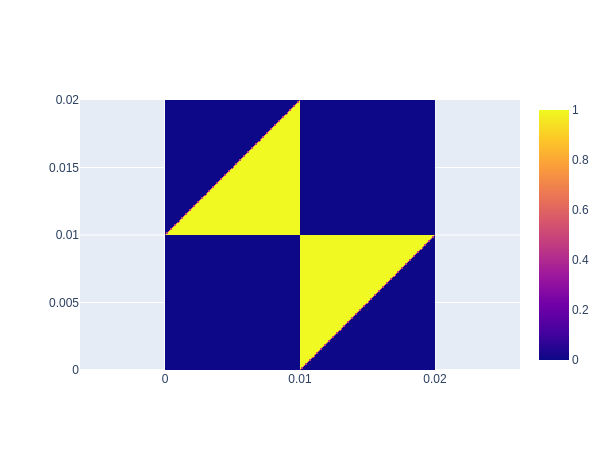

In [36]:
w, h = 2e2, 2e2
nx, ny = 1e4, 1e4
cx, cy = 2e3, 2e3

x = da.from_array(cp.linspace(0, 1, int(nx)), chunks=cx, asarray=False)
y = da.from_array(cp.linspace(0, 1, int(ny)), chunks=cy, asarray=False)
# x = da.linspace(0, 1, nx, chunks=cx)
# y = da.linspace(0, 1, ny, chunks=cy)
# y = da.linspace(0, 1, 10e3)[:, None].rechunk(chunks=1e3)

xx, yy = da.meshgrid(x, y)
# xx, yy = x, y
display(xx)

istriangle = lambda a, b, c: (a + b > c) & (c + a > b) & (b + c > a)

# x < y
a = xx; b = yy - xx; c = 1 - yy
cond0 = istriangle(a, b, c) & (xx < yy)

# x > y
a = yy; b = xx - yy; c = 1 - xx
cond1 = istriangle(a, b, c) & (xx > yy)

cond = cond0 | cond1

dx, dy = nx // w, ny // h
cond_resmpl = da.coarsen(cp.mean, cond, {0: int(dx), 1: int(dy)})#, trim_excess=True)
display(cond_resmpl)
# cond0_resmpl, = dask.optimize(cond_resmpl)
# display(cond_resmpl)

x_r, y_r = x[::dx], y[::dy]
xx_r, yy_r = da.meshgrid(x_r, y_r)
# xc, yc = %time da.compute(x, y)
# cond_resmpl_c = %time cond_resmpl.compute()
xc, yc = %time da.compute(x, y)
cond_resmpl_c = %time cond_resmpl.compute()

data = go.Heatmap(
    x=cp.asnumpy(xc),
    y=cp.asnumpy(yc),
    z=cp.asnumpy(cond_resmpl_c)
)

layout = go.Layout(yaxis=dict(scaleanchor="x", scaleratio=1))

fig = go.Figure(data, layout)

fig.show()

# Solve II

 \begin{equation}
   a + b > c { \ \Rightarrow \ }
   1 - c > c { \ \Rightarrow \ }
   c < \frac 1 2
 \end{equation}
 \begin{equation}
   c + a > b { \ \Rightarrow \ }
   1 - b > b { \ \Rightarrow \ }
   b < \frac 1 2
 \end{equation}
 \begin{equation}
   b + c > a { \ \Rightarrow \ }
   1 - a > a { \ \Rightarrow \ }
   a < \frac 1 2
 \end{equation}

\begin{align}
   & P \left( a + b > c, \, c + a > b, \, b + c > a \right) \\
={}& P \left( a < \frac 1 2, \, b < \frac 1 2, \, c < \frac 1 2 \right) \\
={}& \left. P(a < x) \, P(b < y \, | \, a < x) \, P(c < z \, | \, a < x, \, b < y) \right|_{x = y = z = \frac 1 2}
\end{align}

# Generating samples

In [58]:
n_smpl = 1e7

x = da.random.uniform(0, 1, (2, n_smpl))
# x = da.random.uniform(0, 1, (2, n_smpl), chunks=(2, 5e4))
display(x)

min_ = da.minimum(x[0], x[1])
max_ = da.maximum(x[0], x[1])

a = min_
b = max_ - min_
c = 1 - max_

prob = da.count_nonzero((a < 1 / 2) & (b < 1 / 2) & (c < 1 / 2)) / n_smpl
display(prob)

%time prob.compute()

dask.array<uniform, shape=(2, 10000000), dtype=float64, chunksize=(2, 5000000), chunktype=numpy.ndarray>

dask.array<truediv, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

CPU times: user 834 ms, sys: 185 ms, total: 1.02 s
Wall time: 537 ms


0.2500172

# Analysis

dask.array<truediv, shape=(100,), dtype=float64, chunksize=(100,), chunktype=numpy.ndarray>

CPU times: user 11 s, sys: 4.47 s, total: 15.5 s
Wall time: 5.4 s


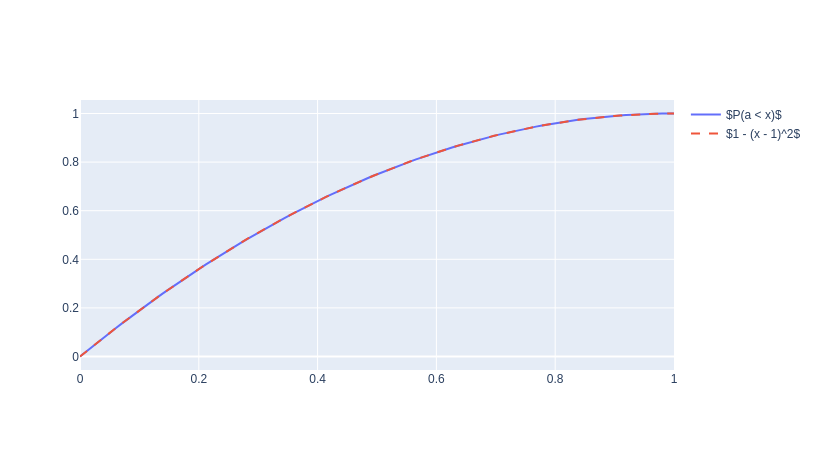

In [98]:
x = da.linspace(0, 1, 100)
P = da.count_nonzero(a.rechunk(2.5e5) < x[:, None], axis=1) / n_smpl
display(P)

P_c = %time P.compute()


P = go.Scatter(x=x, y=P_c, name=r'$P(a < x)$',
                line=dict())
f = go.Scatter(x=x, y=1 - (x - 1)**2, name=r'$1 - (x - 1)^2$',
                     line=dict(dash='dash'))

fig = go.Figure([P, f])

fig.show()

In [106]:
k = 100
x = da.linspace(0, 1, k)
y = da.linspace(0, 1, k)
xx, yy = da.meshgrid(x, y)
Pxy = da.count_nonzero((a.rechunk(0.5e4) < xx[..., None]) & (b.rechunk(0.5e4) < yy[..., None]), axis=2) / n_smpl
Pxy#.compute()

dask.array<truediv, shape=(100, 100), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

In [19]:
n_smpl = 1e6

x = da.random.uniform(0, 1, (2, n_smpl))
# x = da.random.uniform(0, 1, (2, n_smpl), chunks=(2, 0.5e4))
# display(x)

min_ = da.minimum(x[0], x[1])
max_ = da.maximum(x[0], x[1])

a = min_
b = max_ - min_
c = 1 - max_

In [10]:
chunk = 500
k = 1000
x = da.linspace(0, 1, k, chunks=chunk)
y = da.linspace(0, 1, k, chunks=chunk)
# y = da.linspace(0, 1, k)[:, None]
xx, yy = da.meshgrid(x, y)
# xx, yy = x, y

chunk = 500
cond_x = a.rechunk(chunk) < xx[..., None]
cond_y = b.rechunk(chunk) < yy[..., None]
cond = cond_x & cond_y

Pxy = da.count_nonzero(cond, axis=2) / n_smpl
display(xx, cond_x, cond)
display(Pxy)
# %time Pxy.compute()

dask.array<broadcast_to, shape=(1000, 1000), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>

dask.array<lt, shape=(1000, 1000, 1000000), dtype=bool, chunksize=(500, 500, 500), chunktype=numpy.ndarray>

dask.array<and_, shape=(1000, 1000, 1000000), dtype=bool, chunksize=(500, 500, 500), chunktype=numpy.ndarray>

dask.array<truediv, shape=(1000, 1000), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>

In [25]:
chunk = 100
k = 100
x = da.linspace(0, 1, k, chunks=chunk)
y = da.linspace(0, 1, k, chunks=chunk)
# y = da.linspace(0, 1, k)[:, None]
xx, yy = da.meshgrid(x, y)
# xx, yy = x, y

chunk = 500 * 5 * 5
a_ = a.rechunk(chunk)
b_ = b.rechunk(chunk)
cond_x = a_ < xx[..., None]
cond_y = b_ < yy[..., None]
cond = cond_x & cond_y

Pxy = da.count_nonzero(cond, axis=2) / n_smpl
display(xx, cond_x, cond)
display(Pxy)
Pxy_c = %time Pxy.compute()

dask.array<broadcast_to, shape=(100, 100), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

dask.array<lt, shape=(100, 100, 1000000), dtype=bool, chunksize=(100, 100, 12500), chunktype=numpy.ndarray>

dask.array<and_, shape=(100, 100, 1000000), dtype=bool, chunksize=(100, 100, 12500), chunktype=numpy.ndarray>

dask.array<truediv, shape=(100, 100), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

CPU times: user 1min 43s, sys: 1min 7s, total: 2min 51s
Wall time: 1min 10s


In [30]:
chunk = 100
k = 100
x = da.linspace(0, 1, k, chunks=chunk)
y = da.linspace(0, 1, k, chunks=chunk)
# y = da.linspace(0, 1, k)[:, None]
xx, yy = da.meshgrid(x, y)
# xx, yy = x, y

chunk = 500 * 5 * 5
a_ = a.rechunk(chunk).persist()
cond_x = a_ < xx[..., None]
cond_y = b_ < yy[..., None]
# cond_x = cond_x.persist()
# cond_y = cond_y.persist()
cond = cond_x & cond_y

Pxy = da.count_nonzero(cond, axis=2) / n_smpl
display(xx, cond_x, cond)
display(Pxy)
Pxy_c = %time Pxy.compute()

dask.array<broadcast_to, shape=(100, 100), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

dask.array<lt, shape=(100, 100, 1000000), dtype=bool, chunksize=(100, 100, 12500), chunktype=numpy.ndarray>

dask.array<and_, shape=(100, 100, 1000000), dtype=bool, chunksize=(100, 100, 12500), chunktype=numpy.ndarray>

dask.array<truediv, shape=(100, 100), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

CPU times: user 1min 43s, sys: 1min 3s, total: 2min 47s
Wall time: 1min 7s


In [ ]:
%%time
import matplotlib.ticker as ticker


ax = plt.subplot(xlabel='x', ylabel='y')#, title=r'$P(a < x, b < x)$')
plt.title(r'$\frac {\partial^2 P(a < x, b < y)} {\partial x \partial y}$')
# ax.xaxis.set_major_locator(ticker.MultipleLocator(0.25))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))

k = 201
d = 0.1
y, x = np.ogrid[0:1:k * 1j, 0:1:k * 1j]
Pxy = %time np.count_nonzero((a < x[..., None]) & (c < y), axis=2) / n_smpl
DPxy = np.gradient(np.gradient(Pxy, x[:, 0], axis=0), y[0, :], axis=1)
# DPxy = np.gradient(np.gradient(Pxy, x[0, :], axis=0), y[:, 0], axis=1)

plt.pcolormesh(x, y, DPxy, shading='nearest')
plt.colorbar()


# step = 1 / 2
# levels = np.arange(-2, 4 + step / 2, step)
# levels[-1] -= 1e-5

# plt.pcolormesh(
#     x, y,
#     np.gradient(np.gradient(Pxy, x[:, 0], axis=0), y[0, :], axis=1),
#     levels, cmap='hsv'
# )


# plt.tight_layout()
plt.show()

In [ ]:
k = 101
d = 0.1
y, x = np.ogrid[0:1:k * 1j, 0:1:k * 1j]
Pxy = %timeit np.count_nonzero((a < x[..., None]) & (b < y[..., None]), axis=2) / n_smpl

In [ ]:
wX, wx = 7, 7

na = a.shape[0] // wX
nb = b.shape[0] // wX
nx = x.shape[1] // wx
ny = y.shape[0] // wx

nla = a.shape[0] - na * wX
nlb = b.shape[0] - nb * wX
nlx = x.shape[1] - nx * wx
nly = y.shape[0] - ny * wx

na, nb, nx, ny, nla, nlb, nlx, nly

In [ ]:
for ia, ib, ix, iy in product( *(range(n) for n in (2, 2, 2, 2)) ):
a_ = a[wa * ia: wa * (ia + 1)]
# b_ = b[wb * ib: wb * (ib + 1)]
# x_ = x[:, wx * ix: wx * (ix + 1)]
# y_ = y[wy * iy: wy * (iy + 1), :]

a1 = np.empty(a.shape)
a1[:]

In [ ]:
Pxy2_ = np.count_nonzero((a_ < x_[..., None]) & (b_ < y_[..., None]), axis=2) / n_smpl

In [ ]:
Pxy2 = %timeit np.array([np.count_nonzero((a < x_) & (b < y_)) / n_smpl for x_ in x.flatten() for y_ in y.flatten()]).reshape(k, k)
np.allclose(Pxy, Pxy2)

In [ ]:
Pxy1 = %time np.count_nonzero((a < x.T) & (b < y), axis=0) / n_smpl

In [ ]:
np.allclose(Pxy, Pxy1)

In [ ]:
Pxy2 = %time np.count_nonzero((a[:, None, None] < x) & (b[:, None, None] < y), axis=0) / n_smpl

In [ ]:
Pxy2 = %time np.count_nonzero((a[None, :, None] < x[:, None, :]) & (b[None, :, None] < y[:, None, :]), axis=1) / n_smpl

In [ ]:
%time a < x[..., None]
%time a < x[:, :, None]
%time a[:, None, None] < x
%time a[None, :, None] < x[:, None, :]
None

In [ ]:
np.allclose(Pxy1, Pxy2)

$${{f_{i, j} - f_{i-1, j} \over x_{i, j} - x_{i-1, j}} - \left. { f_{i, j} - f_{i-1, j} \over x_{i, j} - x_{i-1, j}} \right|_{j=j-1} \over y_{i, j} - y_{i, j-1}}$$

In [ ]:
f = x * y

In [ ]:
%%timeit
Df = np.gradient(np.gradient(f, x[:, 0], axis=0), y[0, :], axis=1)
# print(Df)

In [ ]:
%%timeit
df = (f[:-1, :] - f[1:, :]) / (x[:-1, :] - x[1:, :])
Df = (df[:, :-1] - df[:, 1:]) \
     / (y[:-1, :-1] - y[:-1, 1:])
# print(Df)

In [ ]:
%timeit ((f[:-1, :-1] - f[1:, :-1]) - (f[:-1, 1:] - f[1:, 1:])) \
       / (x[:-1, :-1] - x[1:, :-1]) / (y[:-1, :-1] - y[:-1, 1:])
%timeit (f[:-1, :-1] - f[1:, :-1] - f[:-1, 1:] + f[1:, 1:]) \
       / (x[:-1, :-1] - x[1:, :-1]) / (y[:-1, :-1] - y[:-1, 1:])


# Calculations

\begin{align}
   P(X < x, \, Y < y, \, Z < y)
&= P(X < x, Y < y) \, P(Z < z \, | \, X = x, \, Y = y) \\
&= P(X < x) \, P(Y < y \, | \, X = x) \, P(Z < z \, | \, X = x, \, Y = y)
\end{align}

\begin{align}
   P(X < x, \, Y < y, \, Z < y)
&= P(X < x, Y < y) \, P(Z < z \, | \, X < x, \, Y < y) \\
&= P(X < x) \, P(Y < y \, | \, X < x) \, P(Z < z \, | \, X < x, \, Y < y)
\end{align}

$$P(X < x, Y < y)= P(X < x) \, P(Y < y \, | \, X < x)$$

In [ ]:
n_smpl = 10000

a = np.random.uniform(0, 1, n_smpl)
b = np.random.uniform(0, 1, n_smpl)
X = np.maximum(a, b)
Y = np.minimum(a, b)


# n = 100
# x = np.mgrid[-1:2:n * 1j]
# P = [np.count_nonzero(X <= x_) / n_smpl for x_ in x]

# plt.xlabel('$x$')
# plt.ylabel('$P$')

# plt.step(x, P, where='post')

# plt.show()


n = 100
x, y = np.mgrid[-1:2:n * 1j, -1:2:n * 1j]
xy = zip(x.flatten(), y.flatten())

Pxy = np.array([np.count_nonzero((X <= x) & (Y <= y)) / n_smpl for x, y in xy]).reshape(x.shape)

# plt.pcolormesh(x, y, P, vmin=0, vmax=1, cmap='hsv')
plt.contour(x, y, Pxy, levels=5, vmin=0, vmax=1, cmap='hsv', linestyles='solid')
# plt.colorbar()
plt.show()


n = 100
x, y = np.mgrid[-1:2:n * 1j, -1:2:n * 1j]
xy = zip(x.flatten(), y.flatten())

Pxy = np.array([np.count_nonzero((X <= x) & (Y <= y)) / n_smpl for x, y in xy]).reshape(x.shape)
Px = np.array([np.count_nonzero(X <= x_) / n_smpl for x_ in x.flatten()]).reshape(x.shape)
PyIx = Pxy / Px
Py = np.array([np.count_nonzero(Y <= y_) / n_smpl for y_ in y.flatten()]).reshape(x.shape)

plt.contour(x, y, PyIx, levels=5, vmin=0, vmax=1, cmap='hsv', linestyles='solid')
plt.contour(x, y, Py, levels=5, vmin=0, vmax=1, cmap='hsv', linestyles='dashed')
# plt.colorbar()

plt.show()


In [ ]:
import numpy as np
from time import time

# Let's take the randomness out of random numbers (for reproducibility)
np.random.seed(0)

size = 4096
A, B = np.random.random((size, size)), np.random.random((size, size))
C, D = np.random.random((size * 128,)), np.random.random((size * 128,))
E = np.random.random((int(size / 2), int(size / 4)))
F = np.random.random((int(size / 2), int(size / 2)))
F = np.dot(F, F.T)
G = np.random.random((int(size / 2), int(size / 2)))

# Matrix multiplication
N = 20
t = time()
for i in range(N):
    np.dot(A, B)
delta = time() - t
print('Dotted two %dx%d matrices in %0.2f s.' % (size, size, delta / N))
del A, B

In [ ]:
import numpy as np
n_smpl = 100000
n_grid = 1001
# n_smpl = 100000
# n_grid = 1001
a = np.random.rand(n_smpl)
x = np.mgrid[0:1:n_grid * 1j]

In [ ]:
%timeit a[None, :] < x[:, None]
%timeit a[:, None] < x[None, :]
%timeit a < x[:, None]
%timeit a[:, None] < x
None

In [ ]:
r1 = %timeit a[None, :] < x[:, None]
r2 = %timeit np.less(a[None, :], x[:, None])
r3 = np.empty((n_grid, n_smpl))
%timeit np.less(a[None, :], x[:, None], r3)
# np.allclose(r1, r2), \
# np.allclose(r1, r3)

In [ ]:
%timeit a[np.newaxis, :] < x[:, np.newaxis]
%timeit np.less(a[np.newaxis, :], x[:, np.newaxis])

In [ ]:
import numpy as np

# memory allocations (everything works fine)
a = np.zeros((1192953, 192, 32), dtype='f8')
b = np.zeros((1192953, 192), dtype='f8')
c = np.zeros((192, 32), dtype='f8')

# a[:] = b[:, :, np.newaxis] - c[np.newaxis, :, :] # memory explodes here

In [ ]:
%timeit a[None, :] < x[:, None]
%timeit np.less(a[None, :], x[:, None])

In [ ]:
r = np.empty((n_smpl, n_grid))
%timeit np.less(a[None, :], x[:, None], r)
None

In [ ]:
r.nbytes

In [ ]:
P1 = %time [np.count_nonzero(a < x_) / n_smpl for x_ in x]
# %time np.count_nonzero((a[None, :] < x[:, None]), axis=1) / n_smpl
# %time np.count_nonzero((a[:, None] < x[None, :]), axis=0) / n_smpl
# %time np.count_nonzero((a < x[:, None]), axis=1) / n_smpl
# %time np.count_nonzero((a[:, None] < x), axis=0) / n_smpl

In [ ]:
# P2 = %time np.count_nonzero((np.less(a, x[:, None])), axis=1) / n_smpl;
P2 = %time np.count_nonzero((a < x[:, None]), axis=1) / n_smpl;

In [ ]:
np.allclose(P1, P2)

In [ ]:
# x0 = [[0, 0], [1, 1]]
# y0 = [[0, 1], [0, 1]]
# z0 = [[0]]

x0 = [[0, 0], [1, 1], [1, 0], [0, -1/2]]
y0 = [[0, 1], [0, 1/2], [2, 3], [4, 4]]
z0 = [[0], [1], [2]]

# x0, y0, z0 = [np.array(x) for x in [x0, y0, z0]]

# x = np.concatenate([x0, x0])
# y = np.concatenate([y0, y0])
# z = np.concatenate([z0, z0])
x, y, z = x0, y0, z0
plt.pcolor(x, y, z, shading='flat')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def mandelbrot( h,w, maxit=20 ):
    """Returns an image of the Mandelbrot fractal of size (h,w)."""
    y,x = np.ogrid[ -1.4:1.4:h*1j, -2:0.8:w*1j ]
    c = x+y*1j
    z = c
    divtime = maxit + np.zeros(z.shape, dtype=int)

    for i in range(maxit):
        z = z**2 + c
        diverge = z*np.conj(z) > 2**2            # who is diverging
        div_now = diverge & (divtime==maxit)  # who is diverging now
        divtime[div_now] = i                  # note when
        z[diverge] = 2                        # avoid diverging too much

    return divtime


plt.pcolormesh(mandelbrot(1000,1000), shading='gourard')
# plt.gca().pcolorfast(mandelbrot(400,400))